# **Telco Customer Churn Prediction**
## **Overview**
Customer churn refers to the loss of customers who no longer use a company's product or service within a time period. This problem is measured as a percentage of lost customers relative to the total customers. Sustained high churn rates will reduce the company's revenue and impact long-term viability. Hence, this metric needs to be monitored closely and rectified if any spikes or upward trend occur.

This project aims to
- Identify key drivers of customer churn
- Build ML models to predict customer churn
- Compare NN vs XGBoost models

---

## **Dataset Description**
This project uses the [**Telco Customer Churn**](https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download) dataset, originally provided as part of the **IBM Sample Data Sets**.

Each row in the dataset represents a single customer, while each column describes the customer attribute.

### Data Contents
The dataset contains the following categories of information:

#### 1. Customer Churn
- **Churn**: Indicates whether the customer left the company within the last month (`Yes` / `No`).

#### 2. Subscribed Services
Information about the services each customer has signed up for, including:
- Phone service and multiple lines
- Internet service (DSL, fiber optic, or none)
- Online security and backup
- Device protection and technical support
- Streaming TV and streaming movies

#### 3. Account Information
Details related to the customer’s account and billing:
- Tenure (length of time as a customer)
- Contract type
- Payment method
- Paperless billing status
- Monthly charges
- Total charges

#### 4. Demographic Information
Basic customer characteristics:
- Gender
- Senior citizen status
- Partner and dependent information

## **Setups**

1. Create and activate venv, run in terminal:

    ```bash
    python -m venv .venv
    .venv\Scripts\Activate
    ```

2. Install requirements

    ```bash
    pip install -r requirements.txt
    ```

3. This notebook uses torch with gpu (cuda 13.0), you can use torch cpu instead but remove the `to(device)` from the code and modify the torch version and URL in `requirements.txt`

In [65]:
# Imports
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Data Processing and Assessment
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
# Machine Learning Models
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
# feature importance
import shap

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available:  {torch.cuda.is_available()}")
print(f"CUDA Version:    {torch.version.cuda}")
print(f"GPU Count:       {torch.cuda.device_count()}")
print(f"Using Device:    {device}")
if torch.cuda.is_available():
    print(f"Current GPU:     {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.9.1+cu130
CUDA Available:  True
CUDA Version:    13.0
GPU Count:       1
Using Device:    cuda
Current GPU:     NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
def set_random_seed(seed: int = 42) -> None:
    """Sets the random seed for reproducibility across multiple libraries."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    # If you are using CUDA (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # for multi-GPU setups
        # For completely deterministic results on GPU, may impact performance
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

# Usage
SEED_VALUE = 0
set_random_seed(SEED_VALUE)


Random seed set as 0


In [4]:
df = pd.read_csv("TelcoChurnData.csv")

## **Checks and Fixes**

### 1. See first few rows

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 2. Check columns, and null values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


> 1. No immediate null values, but could have empty strings / null equivalent strings <br>
> 2. TotalCharges should be a numeric column

### 3. Column type fix

In [7]:
# Total charges should be a numeric column
# Check for non numeric values
invalid_mask = pd.to_numeric(df['TotalCharges'], errors='coerce').isna()
'"' + df.loc[invalid_mask, 'TotalCharges'] + '"'

488     " "
753     " "
936     " "
1082    " "
1340    " "
3331    " "
3826    " "
4380    " "
5218    " "
6670    " "
6754    " "
Name: TotalCharges, dtype: object

In [8]:
# Change whitespace only values above to be nan
df['TotalCharges'] = df['TotalCharges'].replace(r'^\s+$', np.nan, regex=True)
df.loc[invalid_mask, 'TotalCharges']

488     NaN
753     NaN
936     NaN
1082    NaN
1340    NaN
3331    NaN
3826    NaN
4380    NaN
5218    NaN
6670    NaN
6754    NaN
Name: TotalCharges, dtype: object

In [9]:
# Change col type to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [10]:
# Find a way to fill the nan values
# Perhaps we can get total charges from monthly charges multiplied by tenure
test_df = df.loc[~invalid_mask, ['tenure','MonthlyCharges','TotalCharges']]
test_df['MaybeTotalCharges'] = test_df['tenure'] * test_df['MonthlyCharges']
test_df['Diff'] = abs((test_df['MaybeTotalCharges'] - test_df['TotalCharges']) / test_df['TotalCharges'])
test_df.sort_values(by='Diff', ascending=False)
# Unfortunately there's a difference between the calculation and the real value

,tenure,MonthlyCharges,TotalCharges,MaybeTotalCharges,Diff
2950,4,20.20,55.70,80.80,0.450628
4203,7,20.05,96.80,140.35,0.449897
900,2,19.50,27.55,39.00,0.415608
4262,2,66.40,94.55,132.80,0.404548
5595,2,19.40,61.05,38.80,0.364455
...,...,...,...,...,...
5736,1,20.05,20.05,20.05,0.000000
6933,1,69.60,69.60,69.60,0.000000
6943,1,30.50,30.50,30.50,0.000000
1491,1,19.55,19.55,19.55,0.000000


In [11]:
# Check the difference distribution, if small then it's a pretty good approximation
pd.cut(test_df['Diff'],bins=[x/100 for x in range(0,101,10)]).value_counts()

Diff
(0.0, 0.1]    6032
(0.1, 0.2]     317
(0.2, 0.3]      53
(0.3, 0.4]      12
(0.4, 0.5]       4
(0.5, 0.6]       0
(0.6, 0.7]       0
(0.7, 0.8]       0
(0.8, 0.9]       0
(0.9, 1.0]       0
Name: count, dtype: int64

In [12]:
# The distribution seems ok, check the calculation for the nan values
df.loc[invalid_mask, 'TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'])

488     0.0
753     0.0
936     0.0
1082    0.0
1340    0.0
3331    0.0
3826    0.0
4380    0.0
5218    0.0
6670    0.0
6754    0.0
Name: TotalCharges, dtype: float64

In [13]:
# Oddly all are zeros, check the tenure and monthly charges
df.loc[invalid_mask, ['tenure','MonthlyCharges']]

,tenure,MonthlyCharges
488,0,52.55
753,0,20.25
936,0,80.85
1082,0,25.75
1340,0,56.05
3331,0,19.85
3826,0,25.35
4380,0,20.00
5218,0,19.70
6670,0,73.35


In [14]:
# Check for similar cases of tenure 0, is there one where the TotalCharges is not null
df.loc[df['tenure']==0,['tenure','MonthlyCharges','TotalCharges']]

,tenure,MonthlyCharges,TotalCharges
488,0,52.55,NaN
753,0,20.25,NaN
936,0,80.85,NaN
1082,0,25.75,NaN
1340,0,56.05,NaN
3331,0,19.85,NaN
3826,0,25.35,NaN
4380,0,20.00,NaN
5218,0,19.70,NaN
6670,0,73.35,NaN


In [15]:
# Since the are no similar cases, a decision must be made
# Though it is preferable to get more context of the data if possible

# For now, since we know that the tenure is in months, then 0 must mean the customer churned before the first billing
# This means the TotalCharges must be either the MonthlyCharge if there is no free cancelation policy
# Or TotalCharges must be 0 if there is a free cancelation policy

# A free cancelation policy is uncommon for a telco subscription, so we'll set it to the MonthlyCharge
df.loc[invalid_mask, 'TotalCharges'] = df.loc[invalid_mask, 'MonthlyCharges']
df.loc[invalid_mask, ['TotalCharges','MonthlyCharges']]

,TotalCharges,MonthlyCharges
488,52.55,52.55
753,20.25,20.25
936,80.85,80.85
1082,25.75,25.75
1340,56.05,56.05
3331,19.85,19.85
3826,25.35,25.35
4380,20.00,20.00
5218,19.70,19.70
6670,73.35,73.35


### 4. Check string columns values, look for odd or null equivalent values

In [16]:
# Check unique values, especially for text data
for column in df.select_dtypes(include=['object']).columns:
    if column == 'customerID':
        continue
    unique_values = sorted(df[column].unique().tolist())
    print(f"{column:<25} | {len(unique_values):<5} units | {unique_values}")

gender                    | 2     units | ['Female', 'Male']
Partner                   | 2     units | ['No', 'Yes']
Dependents                | 2     units | ['No', 'Yes']
PhoneService              | 2     units | ['No', 'Yes']
MultipleLines             | 3     units | ['No', 'No phone service', 'Yes']
InternetService           | 3     units | ['DSL', 'Fiber optic', 'No']
OnlineSecurity            | 3     units | ['No', 'No internet service', 'Yes']
OnlineBackup              | 3     units | ['No', 'No internet service', 'Yes']
DeviceProtection          | 3     units | ['No', 'No internet service', 'Yes']
TechSupport               | 3     units | ['No', 'No internet service', 'Yes']
StreamingTV               | 3     units | ['No', 'No internet service', 'Yes']
StreamingMovies           | 3     units | ['No', 'No internet service', 'Yes']
Contract                  | 3     units | ['Month-to-month', 'One year', 'Two year']
PaperlessBilling          | 2     units | ['No', 'Yes']
PaymentMe

### 5. Check duplication

In [17]:
# Check for customer duplications
df.value_counts('customerID').map(lambda x: x>1).any()

np.False_

### 6. Sanity checks

In [18]:
# Sanity check
df[df['MonthlyCharges'] > df['TotalCharges']]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [19]:
# Final null check
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [20]:
# drop customer id
df.drop(columns=['customerID'], inplace=True)

## **EDA**

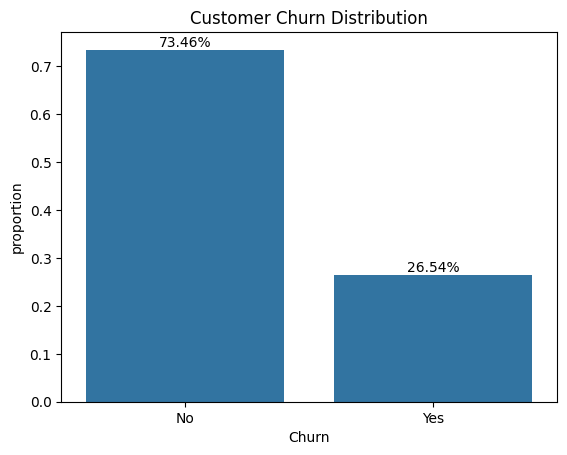

In [21]:
ax = sns.countplot(x='Churn', data=df, stat="proportion")
labels = (df['Churn'].value_counts() / df['Churn'].count() * 100).map(lambda x: f'{x:.2f}%')
ax.bar_label(ax.containers[0], labels = labels) 
plt.title("Customer Churn Distribution")
plt.show()

In [22]:
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
numeric_subplots = [len(numeric_columns), 1] # Adjustable to preference
# SeniorCitizen is binary, we can change the zero/ones to no/yes but its not necessary
category_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling','PaymentMethod']
category_subplots = [4, int(np.ceil(len(category_columns)/4))]

[]

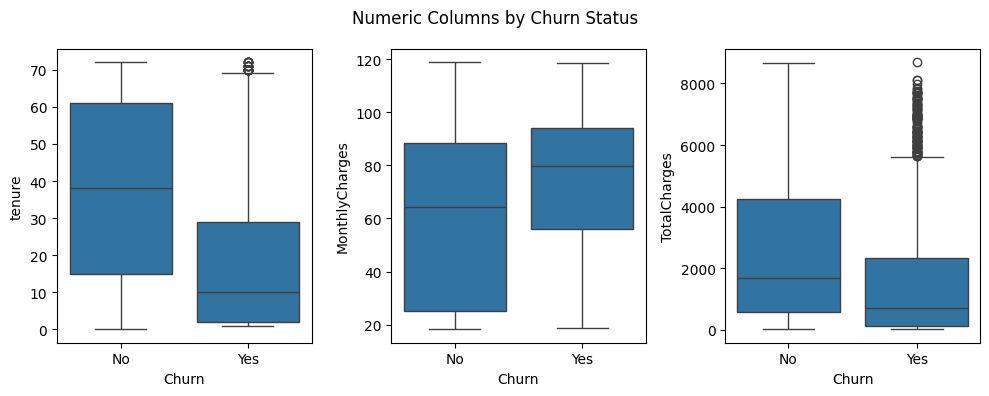

In [23]:
fig, axes = plt.subplots(*reversed(numeric_subplots), figsize=(10,4))

for i in range(len(numeric_columns)):
    ax = axes.flatten()[i]
    column = numeric_columns[i]
    sns.boxplot(x='Churn', y=column, data=df, ax=ax)

fig.suptitle("Numeric Columns by Churn Status")
plt.tight_layout()
plt.plot()

[]

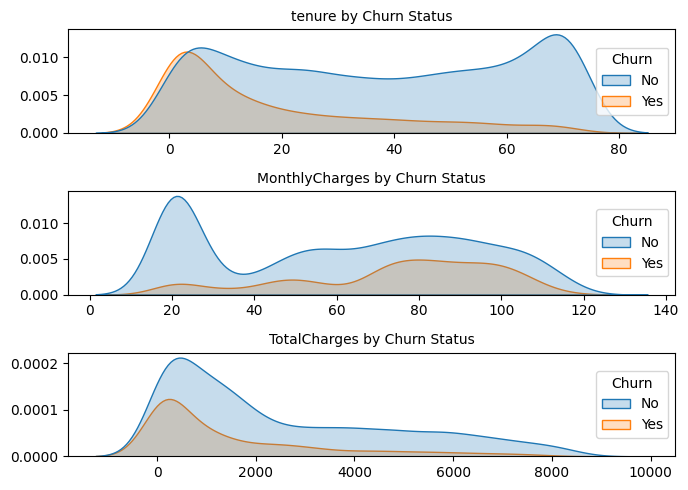

In [24]:
fig, axes = plt.subplots(*numeric_subplots, figsize=(7,5))

for i in range(len(numeric_columns)):
    ax = axes.flatten()[i]
    column = numeric_columns[i]
    sns.kdeplot(x=column, hue='Churn', fill=True, data=df, ax=ax)
    sns.move_legend(ax, 'center right')
    ax.set_title(f'{column} by Churn Status', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.plot()

[]

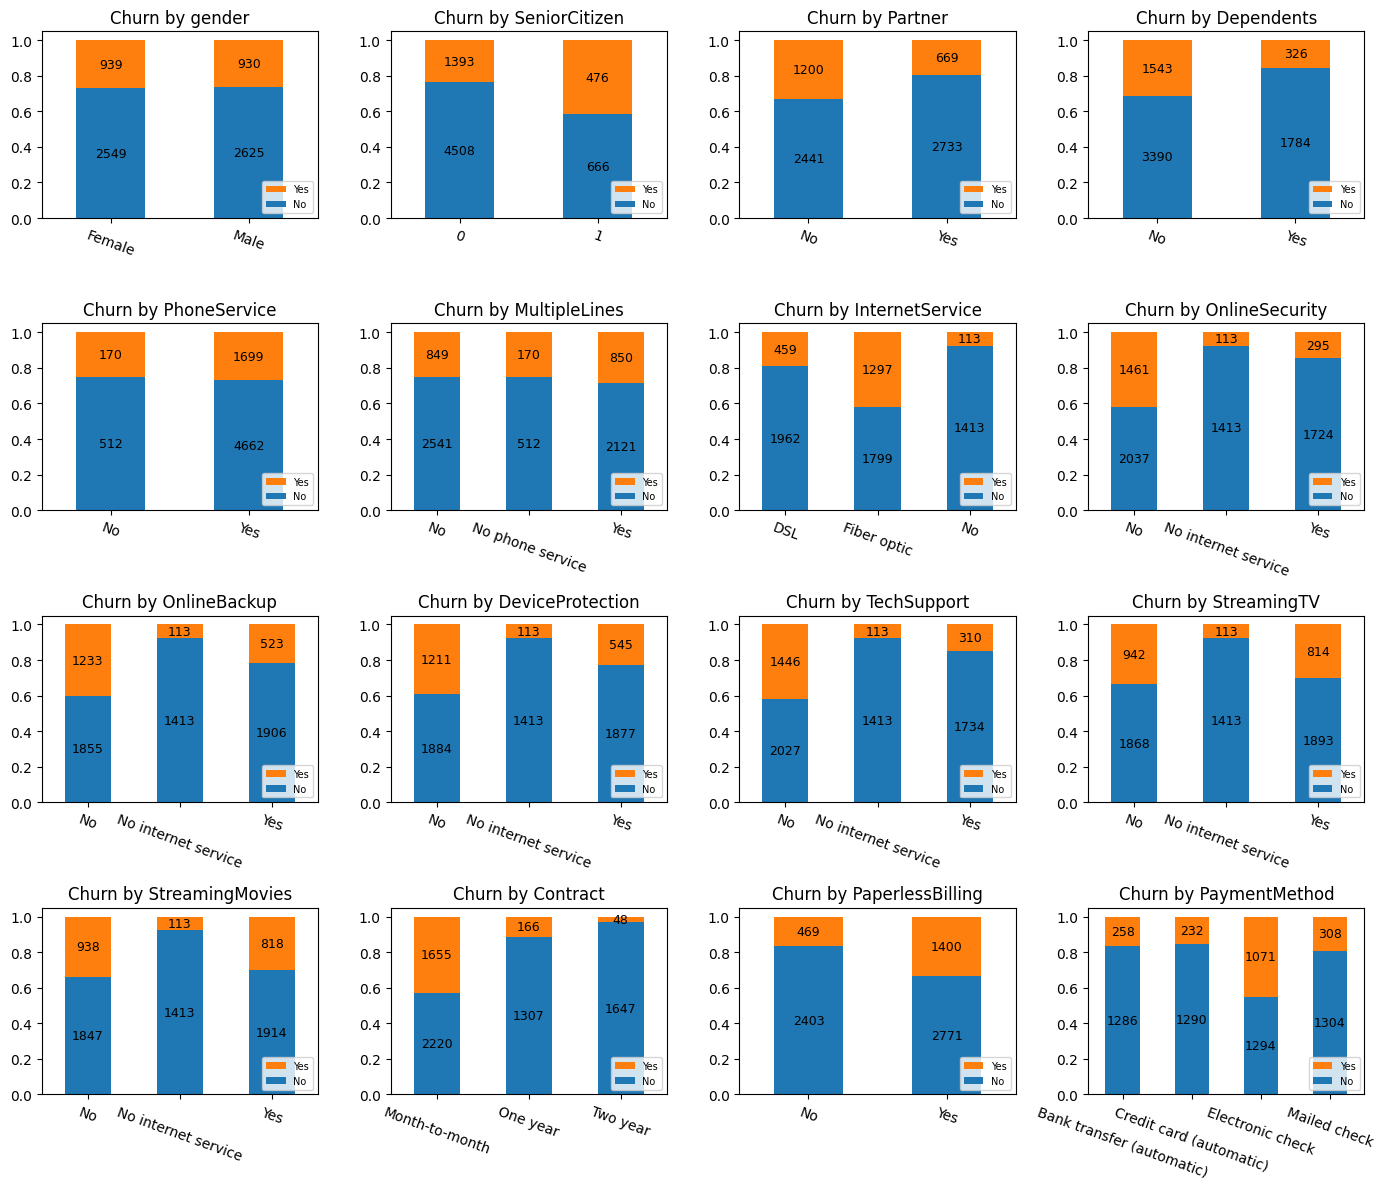

In [25]:
fig, axes = plt.subplots(*reversed(category_subplots), figsize=(14,12))

for i in range(len(category_columns)):
    ax = axes.flatten()[i]
    column = category_columns[i]
    crosstab_norm = pd.crosstab(df[column],df['Churn'], normalize='index')
    crosstab_norm.plot(kind='bar', stacked=True, ax=ax)
    crosstab_count =  pd.crosstab(df[column],df['Churn'])
    # Add count to each bar
    for idx, cat in enumerate(crosstab_count.index):
        cumulative = 0
        for churn_val in crosstab_count.columns:
            count = crosstab_count.loc[cat, churn_val]
            if count == 0:
                continue

            proportion = crosstab_norm.loc[cat, churn_val]
            ax.text(
                idx,
                cumulative + proportion / 2,
                f'{count}',
                ha='center',
                va='center',
                fontsize=9
            )
            cumulative += proportion
    ax.set_title(f'Churn by {column}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-20)
    ax.legend(loc='lower right', reverse=True, fontsize=7)

plt.tight_layout()
plt.plot()

## **Feature Engineering**

In [63]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# 1. TEMPORAL FEATURES (Tenure-based)
df['tenure_stage'] = pd.cut(
    df['tenure'], 
    bins=[0, 6, 12, 24, 48, np.inf],
    labels=['0-6m', '6-12m', '1-2y', '2-4y', '4y+']
)
df['is_new_customer'] = (df['tenure'] <= 6).astype(int)
df['is_loyal'] = (df['tenure'] > 24).astype(int)

# 2. MONETARY FEATURES
df['avg_monthly_charge'] = df['TotalCharges'] / (df['tenure'] + 1)
df['charge_ratio'] = df['MonthlyCharges'] / (df['avg_monthly_charge'] + 1e-5)
monthly_mean = df['MonthlyCharges'].mean()
df['is_high_spender'] = (df['MonthlyCharges'] > monthly_mean * 1.5).astype(int)

# 3. SERVICE ADOPTION FEATURES
internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                     'TechSupport', 'StreamingTV', 'StreamingMovies']
df['num_internet_services'] = df[internet_services].apply(
    lambda row: sum(1 for val in row if val in ['Yes', True]), axis=1
)
df['total_services'] = df['num_internet_services'] + df['PhoneService'].apply(
    lambda x: 1 if x == 'Yes' else 0
)
df['has_premium_services'] = (
    df[['OnlineSecurity', 'TechSupport', 'StreamingTV', 'StreamingMovies']].apply(
        lambda row: sum(1 for val in row if val in ['Yes', True]), axis=1
    ) > 0
).astype(int)

# 4. CONTRACT FEATURES
contract_strength = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df['contract_strength'] = df['Contract'].map(contract_strength)
df['uses_autopay'] = df['PaymentMethod'].isin([
    'Bank transfer (automatic)', 
    'Credit card (automatic)'
]).astype(int)

# 5. DEMOGRAPHIC FEATURES
df['is_senior'] = df['SeniorCitizen']
df['has_partner'] = (df['Partner'] == 'Yes').astype(int)
df['has_dependents'] = (df['Dependents'] == 'Yes').astype(int)

# 6. INTERNET TYPE FEATURES
df['uses_fiber'] = (df['InternetService'] == 'Fiber optic').astype(int)
df['no_internet'] = (df['InternetService'] == 'No').astype(int)

# 7. INTERACTION FEATURES
df['high_charge_no_commitment'] = (
    (df['MonthlyCharges'] > monthly_mean) & 
    (df['Contract'] == 'Month-to-month')
).astype(int)

df['senior_with_fiber'] = (
    (df['is_senior'] == 1) & 
    (df['uses_fiber'] == 1)
).astype(int)

df['new_customer_many_services'] = (
    (df['is_new_customer'] == 1) & 
    (df['total_services'] > 4)
).astype(int)

# 8. BINARY ENCODING FOR CATEGORICAL
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = (df[col] == 'Yes').astype(int)

# Drop unnecessary columns
df = df.drop(['customerID'], axis=1)

print(f"Features after engineering: {df.shape[1]}")
print(f"\nNew features created:")
new_features = ['tenure_stage', 'is_new_customer', 'is_loyal', 'avg_monthly_charge',
                'charge_ratio', 'is_high_spender', 'num_internet_services', 
                'total_services', 'has_premium_services', 'contract_strength',
                'uses_autopay', 'uses_fiber', 'no_internet', 'high_charge_no_commitment',
                'senior_with_fiber', 'new_customer_many_services']
for feat in new_features:
    if feat in df.columns:
        print(f"  ✓ {feat}")

## **String Data Encoding and Stratified K-Fold**

In [26]:
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1})

In [27]:
# Encode x vars
X = pd.get_dummies(X, drop_first=True)

In [28]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

## **Logistic Regression (Baseline)**

In [29]:
auc_scores = []

for train_idx, val_idx in skf.split(X, y):
    # Train validation split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)

    preds = model.predict_proba(X_val_scaled)[:, 1]
    auc = roc_auc_score(y_val, preds)
    auc_scores.append(auc)

print(f"Logistic Regression CV ROC-AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

Logistic Regression CV ROC-AUC: 0.8454 ± 0.0139


## **Neural Networks**

### **1. Basic NN**

In [30]:
# Basic NN
nn_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    # Train validation split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Convert to tensor
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val.values, dtype=torch.float32)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid()
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # Train
    for epoch in range(20):
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb).squeeze(), yb)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        preds = model(X_val_t.to(device)).squeeze().cpu().numpy()

    auc = roc_auc_score(y_val, preds)
    nn_auc_scores.append(auc)

print(f"NN CV ROC-AUC: {np.mean(nn_auc_scores):.4f} ± {np.std(nn_auc_scores):.4f}")


NN CV ROC-AUC: 0.8434 ± 0.0137


### **2. NN with class weights**

#### **Class weights to handle class imbalance**

Most of the customers are non churners. This imbalance can make a model "lazy"—achieving high accuracy by simply predicting "No Churn" for everyone.

How class weights addresses class imbalance:
*   **`compute_class_weight`**: Calculates a "significance multiplier" where the **Majority (Stayed)** gets a small weight (e.g., 0.6) and the **Minority (Churned)** gets a large weight (e.g., 2.5).
*   **`pos_weight`**: This multiplier is passed into `BCEWithLogitsLoss`. It tells the optimizer: *"Missing a Churner is **X times** worse than missing a Stayer."*


In [31]:
# NN with class weights, to emphasize the churners
nn_wcw_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

    # class weight
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_train
    )
    pos_weight = torch.tensor(weights[1], dtype=torch.float32).to(device)

    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1)
        # remove sigmoid, use sigmoid after training, because bcelost doesn't accept class weights but bce with logits does
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    for epoch in range(20):
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb).squeeze(), yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = torch.sigmoid(model(X_val_t.to(device)).squeeze()).cpu().numpy()

    auc = roc_auc_score(y_val, preds)
    nn_wcw_auc_scores.append(auc)

print(f"NN WCW CV ROC-AUC: {np.mean(nn_wcw_auc_scores):.4f} ± {np.std(nn_wcw_auc_scores):.4f}")


NN WCW CV ROC-AUC: 0.8425 ± 0.0138


### **3. Tuned NN with class weights**

In [32]:
# Next: tune nn
def nn_objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    hidden1 = trial.suggest_int("hidden1", 32, 128)
    hidden2 = trial.suggest_int("hidden2", 16, 64)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    auc_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
        X_val_t = torch.tensor(X_val, dtype=torch.float32)

        train_ds = TensorDataset(X_train_t, y_train_t)
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        weights = compute_class_weight(
            class_weight='balanced',
            classes=np.array([0, 1]),
            y=y_train
        )
        pos_weight = torch.tensor(weights[1], dtype=torch.float32).to(device)

        model = nn.Sequential(
            nn.Linear(X_train.shape[1], hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        ).to(device)

        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        # early stopping vars
        best_auc = 0
        patience = 3
        patience_counter = 0

        for epoch in range(30):
            model.train()
            for xb, yb in train_dl:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(xb).squeeze(), yb)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                preds = torch.sigmoid(model(X_val_t.to(device)).squeeze()).cpu().numpy()
                auc = roc_auc_score(y_val, preds)

            if auc > best_auc:
                best_auc = auc
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break

        auc_scores.append(best_auc)

    return np.mean(auc_scores)


In [33]:
nn_sampler = TPESampler(seed=0)
nn_study = optuna.create_study(
    direction="maximize",
    sampler=nn_sampler,
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10) # set to 10 because nn training is expensive
)
nn_study.optimize(nn_objective, n_trials=50)

[I 2026-02-21 15:41:52,369] A new study created in memory with name: no-name-60b9cbfd-3061-4db8-971a-00b19e23c61c
[I 2026-02-21 15:41:59,754] Trial 0 finished with value: 0.84432519972405 and parameters: {'lr': 0.0012520653814999472, 'hidden1': 101, 'hidden2': 45, 'dropout': 0.21795327319875876, 'weight_decay': 1.8662266976517965e-05, 'batch_size': 128}. Best is trial 0 with value: 0.84432519972405.
[I 2026-02-21 15:42:12,564] Trial 1 finished with value: 0.8426942999146156 and parameters: {'lr': 0.008459126528049376, 'hidden1': 69, 'hidden2': 54, 'dropout': 0.2115579679011618, 'weight_decay': 5.059803874660435e-05, 'batch_size': 32}. Best is trial 0 with value: 0.84432519972405.
[I 2026-02-21 15:42:54,671] Trial 2 finished with value: 0.8433646631557655 and parameters: {'lr': 0.00010975815419380165, 'hidden1': 112, 'hidden2': 54, 'dropout': 0.3480048592987277, 'weight_decay': 0.0008626905220714901, 'batch_size': 32}. Best is trial 0 with value: 0.84432519972405.
[I 2026-02-21 15:43:14

In [34]:
print(nn_study.best_value)
for k, v in nn_study.best_params.items():
    print(f"{k:20}: {v}")

0.8450673069150026
lr                  : 0.0015397282290504132
hidden1             : 110
hidden2             : 45
dropout             : 0.2346413351457684
weight_decay        : 1.0015305440030845e-05
batch_size          : 64


C:\Users\Justin Jedidiah\AppData\Local\Temp\ipykernel_17336\1810453840.py:1: ExperimentalWarning:

optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



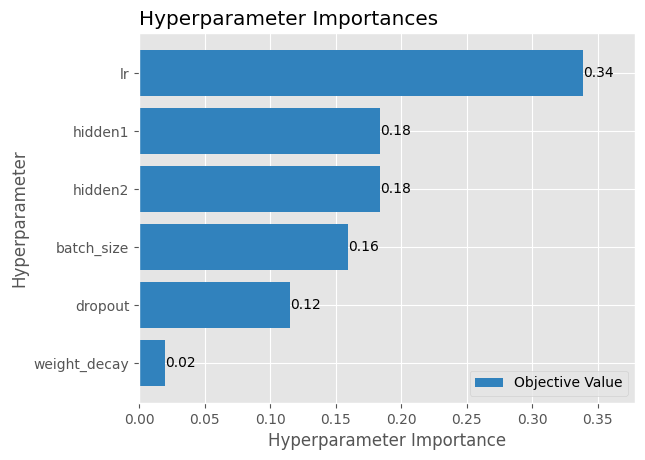

In [62]:
optuna.visualization.matplotlib.plot_param_importances(nn_study)
plt.show()

C:\Users\Justin Jedidiah\AppData\Local\Temp\ipykernel_17336\1983596579.py:1: ExperimentalWarning:

optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



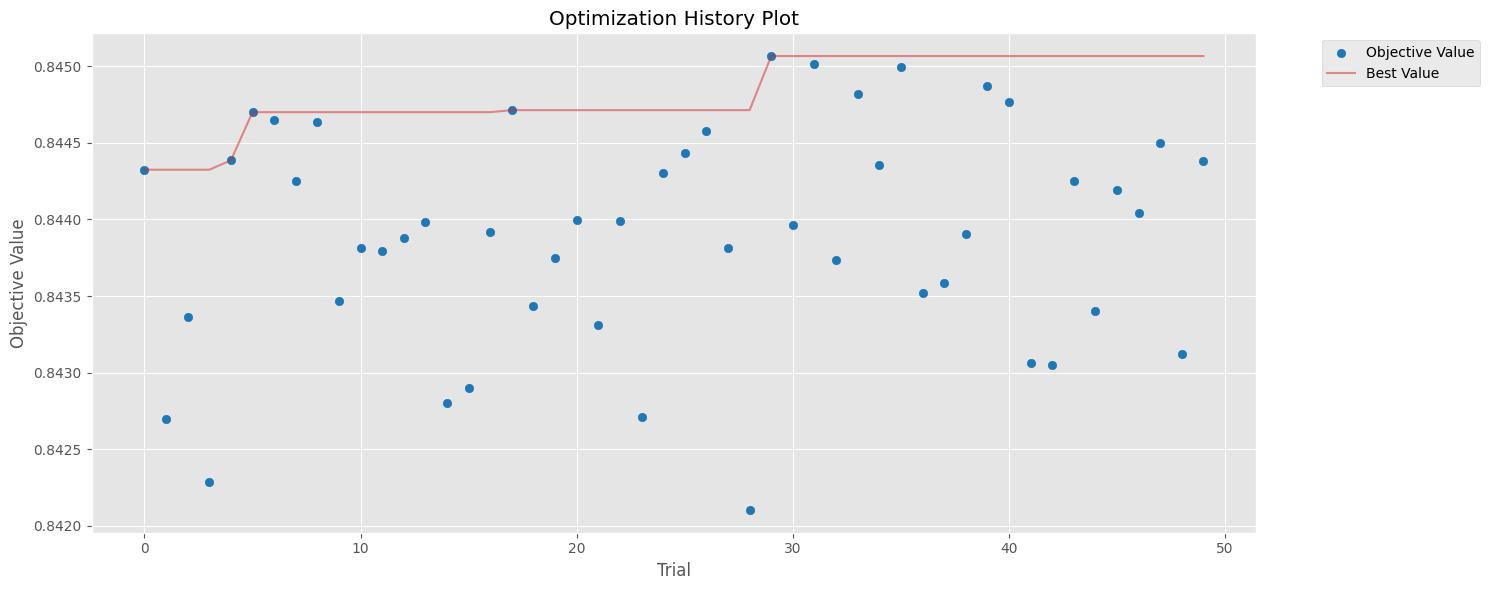

In [61]:
optuna.visualization.matplotlib.plot_optimization_history(nn_study)
fig = plt.gcf()
fig.set_size_inches(15, 6)
plt.show()

## **XGBoost**

### **1. Basic XGBoost**

In [37]:
# XGBoost 
xgb_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    d_train = xgb.DMatrix(
        X_train.values,
        label=y_train.values
    )
    d_val = xgb.DMatrix(
        X_val.values,
        label=y_val.values
    )

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'device': 'cuda',
        'max_depth': 4,
        'eta': 0.05, # learning rate
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 0, # random state
    }

    model = xgb.train(
        params,
        d_train,
        num_boost_round=300,
        evals=[(d_val, "val")],
        verbose_eval=False
    )

    preds = model.predict(d_val)
    auc = roc_auc_score(y_val, preds)
    xgb_auc_scores.append(auc)

print(f"XGB AUC: {np.mean(xgb_auc_scores):.4f} ± {np.std(xgb_auc_scores):.4f}")

XGB AUC: 0.8439 ± 0.0112


### **2. XGBoost with class weights**

In [38]:
# XGBoost with class weights
xgb_wcw_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    d_train = xgb.DMatrix(
        X_train.values,
        label=y_train.values
    )
    d_val = xgb.DMatrix(
        X_val.values,
        label=y_val.values
    )

    # class weights
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'device': 'cuda',
        'max_depth': 4,
        'eta': 0.05, # learning rate
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'scale_pos_weight':scale_pos_weight,
        'seed': 0, # random state
    }

    model = xgb.train(
        params,
        d_train,
        num_boost_round=300,
        evals=[(d_val, "val")],
        verbose_eval=False
    )

    preds = model.predict(d_val)
    auc = roc_auc_score(y_val, preds)
    xgb_wcw_auc_scores.append(auc)

print(f"XGB WCW AUC: {np.mean(xgb_wcw_auc_scores):.4f} ± {np.std(xgb_wcw_auc_scores):.4f}")

XGB WCW AUC: 0.8441 ± 0.0113


### **3. Tuned XGBoost with class weights**

In [39]:
# XGBoost with class weights and hyperparameter tuning
def xgb_objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'device': 'cuda',
        'seed': 0, # random state 
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'eta': trial.suggest_float('eta', 0.01, 0.1, log=True), # learning rate
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0, 0.5), # minimum loss reduction to make a split
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 0.5, 5.0), # regularization lambda, making weights (leaf weights) nudges smaller
    }

    auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X,y),1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
        d_train = xgb.DMatrix(
            X_train.values,
            label=y_train.values
        )
        d_val = xgb.DMatrix(
            X_val.values,
            label=y_val.values
        )
    
        # class weights
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        params["scale_pos_weight"] = scale_pos_weight
        
        model = xgb.train(
            params,
            d_train,
            num_boost_round=1000,
            evals=[(d_val, "val")],
            early_stopping_rounds=50,
            verbose_eval=False
        )
    
        preds = model.predict(d_val, iteration_range=(0, model.best_iteration + 1)) # we only use trees that are good (determined by early stopping), plus one because range is exclusive at the end
        auc_scores.append(roc_auc_score(y_val, preds))
    return np.mean(auc_scores)


In [40]:
xgb_sampler = TPESampler(seed=0)

xgb_study = optuna.create_study(
    direction="maximize",
    sampler = xgb_sampler,
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=50) # set to 50 because xgb training is cheaper than nn
)

xgb_study.optimize(xgb_objective, n_trials=100)


[I 2026-02-21 15:54:51,240] A new study created in memory with name: no-name-96fe8e62-1fa4-4d5a-b51e-89ea3da60793
[I 2026-02-21 15:54:56,059] Trial 0 finished with value: 0.8502961193893247 and parameters: {'max_depth': 4, 'eta': 0.051902630176951646, 'min_child_weight': 13, 'gamma': 0.27244159149844843, 'subsample': 0.7694619197355619, 'colsample_bytree': 0.8583576452266624, 'lambda': 2.4691424506821162}. Best is trial 0 with value: 0.8502961193893247.
[I 2026-02-21 15:54:59,225] Trial 1 finished with value: 0.8482647575987536 and parameters: {'max_depth': 6, 'eta': 0.0919735099256812, 'min_child_weight': 8, 'gamma': 0.3958625190413323, 'subsample': 0.8115579679011617, 'colsample_bytree': 0.827217824437573, 'lambda': 4.665184872316974}. Best is trial 0 with value: 0.8502961193893247.
[I 2026-02-21 15:55:15,306] Trial 2 finished with value: 0.8491673658876533 and parameters: {'max_depth': 2, 'eta': 0.012221634728708948, 'min_child_weight': 1, 'gamma': 0.416309922773969, 'subsample': 0.

In [64]:
print(xgb_study.best_value)
xgb_best_params = xgb_study.best_params.copy()
xgb_best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'device': 'cuda',
    'seed': 0, # random state
})
for k, v in xgb_best_params.items():
    print(f"{k:20}: {v}")


0.8509088691354186
max_depth           : 2
eta                 : 0.06527767625607205
min_child_weight    : 19
gamma               : 0.4344136137111747
subsample           : 0.6604826033708846
colsample_bytree    : 0.7644687033065922
lambda              : 2.7303535483763386
objective           : binary:logistic
eval_metric         : auc
tree_method         : hist
device              : cuda
seed                : 0


C:\Users\Justin Jedidiah\AppData\Local\Temp\ipykernel_17336\3015938784.py:1: ExperimentalWarning:

optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



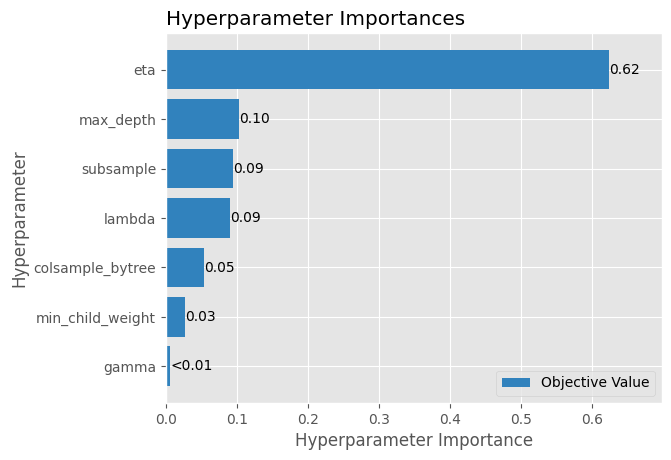

In [47]:
optuna.visualization.matplotlib.plot_param_importances(xgb_study)
plt.show()

C:\Users\Justin Jedidiah\AppData\Local\Temp\ipykernel_17336\419665281.py:1: ExperimentalWarning:

optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



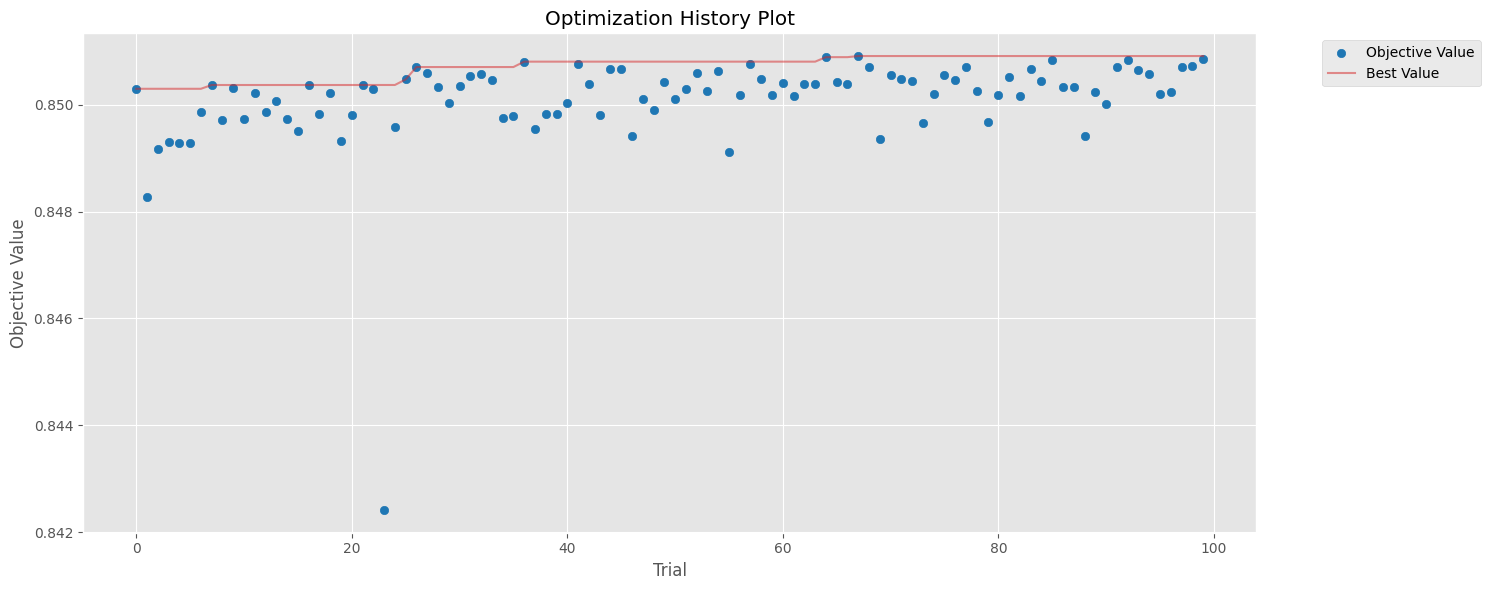

In [59]:
optuna.visualization.matplotlib.plot_optimization_history(xgb_study)
fig = plt.gcf()
fig.set_size_inches(15, 6)
plt.show()

XGBoost SHAP

In [ ]:
# oof = out of fold shap values
xgb_oof_shap_values = np.zeros(X.shape)
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    d_train = xgb.DMatrix(
        X_train.values,
        label=y_train.values
    )
    d_val = xgb.DMatrix(
        X_val.values,
        label=y_val.values
    )

    # class weights
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_best_params["scale_pos_weight"] = scale_pos_weight

    # Retrain the "winning" model
    model = xgb.train(
        xgb_best_params, 
        d_train, 
        num_boost_round=1000,
        evals=[(d_val, "val")], 
        early_stopping_rounds=50, 
        verbose_eval=False
    )

    # --- THE SHAP PART ---
    # TreeExplainer is optimized for XGBoost
    explainer = shap.TreeExplainer(model)
    
    # We explain the validation set to see how the model handles 'unseen' data
    # We use iteration_range to match your early_stopping logic
    fold_shap = explainer.shap_values(
        X_val, 
        iteration_range=(0, model.best_iteration + 1)
    )
    
    # Fill the SHAP values into the global array at the correct row indices
    xgb_oof_shap_values[val_idx] = fold_shap

In [ ]:
# next: do feature engineering based on eda
# use shap to do feature importance and selection after feature engineering
# shap tree for xgboost, shap deep for nn